In [1]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from dtaidistance import dtw
from scipy.signal import correlate
import pmdarima as pm

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
forex_data_hour = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                              interval=Interval.in_15_minute, n_bars=4000)

# Display the last five rows
prices = forex_data_hour['close']
prices

datetime
2024-08-30 06:30:00    2513.13
2024-08-30 06:45:00    2513.59
2024-08-30 07:00:00    2513.63
2024-08-30 07:15:00    2514.57
2024-08-30 07:30:00    2513.42
                        ...   
2024-10-30 17:30:00    2784.01
2024-10-30 17:45:00    2784.74
2024-10-30 18:00:00    2784.93
2024-10-30 18:15:00    2785.42
2024-10-30 18:30:00    2785.82
Name: close, Length: 4000, dtype: float64

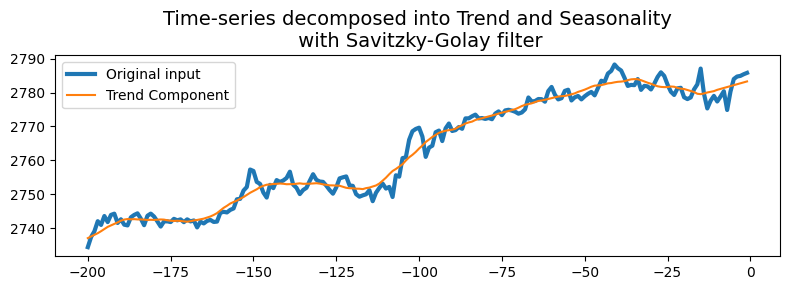

In [2]:
# Save the original time index
original_time_index = prices.index

# Reset the index to 0 to 999
prices = prices.reset_index(drop=True)

yvalues = prices
yvalues_trend = savgol_filter(yvalues,19,1)
yvalues_seasonal = yvalues-yvalues_trend

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-200,0), yvalues[-200:], label='Original input',linewidth=3)
ax.plot(np.arange(-200,0), yvalues_trend[-200:], label='Trend Component')
#ax.plot(yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()


In [3]:
def fft_forecast(signal, forecast_elements, target_harmonics=40):

    # Perform FFT on the seasonal component
    N = len(signal)
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(N)

    # **2. Retain non-negative frequencies (including zero)**
    positive_freq_indices = fft_freq >= 0
    fft_freq_positive = fft_freq[positive_freq_indices]
    fft_result_positive = fft_result[positive_freq_indices]

    # Limit the number of harmonics
    num_harmonics = min(target_harmonics, len(fft_freq_positive))
    frequencies = fft_freq_positive[:num_harmonics]
    amplitudes = fft_result_positive[:num_harmonics]

    # **3. Create extended indices including future points**
    reconstructed_length = N + forecast_elements
    extended_indices = np.arange(reconstructed_length)

    # **4. Reconstruct the signal using the selected harmonics**
    reconstructed_signal = np.zeros(reconstructed_length)

    for i in range(num_harmonics):
        frequency = frequencies[i]
        amplitude_complex = amplitudes[i]
        amplitude = np.abs(amplitude_complex)
        phase = np.angle(amplitude_complex)
        omega = 2 * np.pi * frequency

        if frequency == 0:  # DC component
            reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
        else:
            reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)
    
    return reconstructed_signal, num_harmonics

In [15]:
# Define error metric: Root Mean Squared Error (RMSE)
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [260]:
# Definition of Forecast Parameters
validation_elements = 8
test_elements = 8
seasonal_harmonics_list = np.arange(40, 80, 5)
seasonal_input_elements_list = np.arange(200, 800, 5)
visualization_elements = 120
shift_step = 12
num_runs = 200

# Initialize a list to store results
results = []

for seasonal_harmonics in seasonal_harmonics_list:
    for seasonal_input_elements in seasonal_input_elements_list:
        for run in range(num_runs):
            # Calculate starting index, and get input data slice
            start_idx = len(yvalues_seasonal) - shift_step*run - test_elements - validation_elements - seasonal_input_elements
            input_slice = yvalues_seasonal[start_idx:start_idx+seasonal_input_elements]

            # Generate forecast
            yvalues_seasonal_forecast, num_harmonics = fft_forecast(
                input_slice,
                validation_elements+test_elements,
                seasonal_harmonics
            )
            
            # Convert forecasts to numpy arrays if they're pandas Series
            if isinstance(yvalues_seasonal_forecast, pd.Series):
                yvalues_seasonal_forecast = yvalues_seasonal_forecast.to_numpy()
            if isinstance(yvalues_seasonal, pd.Series):
                yvalues_seasonal = yvalues_seasonal.to_numpy()

            # Extract validation and test portions
            actual_validation = yvalues_seasonal[-validation_elements-test_elements:-test_elements]
            forecast_validation = yvalues_seasonal_forecast[-validation_elements-test_elements:-test_elements]
            actual_test = yvalues_seasonal[-test_elements:]
            forecast_test = yvalues_seasonal_forecast[-test_elements:]

            # Calculate distances
            validation_distance = dtw.distance(actual_validation, forecast_validation)
            test_distance = dtw.distance(actual_test, forecast_test)

            # Calculate cross-correlation for validation set
            validation_cross_corr = correlate(actual_validation, 
                                              forecast_validation, 
                                              mode='full')
            validation_max_corr = max(validation_cross_corr)
            
            # Calculate cross-correlation for test set
            test_cross_corr = correlate(actual_test, 
                                        forecast_test, 
                                        mode='full')
            test_max_corr = max(test_cross_corr)

            # Store the results
            results.append({
                'seasonal_input_length': seasonal_input_elements,
                'seasonal_harmonics': seasonal_harmonics,
                'run': run,
                'rmse_validation': calculate_rmse(actual_validation, forecast_validation),
                'rmse_test': calculate_rmse(actual_test, forecast_test),
                'dtw_validation': validation_distance,
                'dtw_test': test_distance,
                'cc_validation': validation_max_corr,
                'cc_test': test_max_corr
            })

# Create DataFrame and calculate statistics only if we have results
if results:
    results_df = pd.DataFrame(results)
    print("\nSummary Statistics:")
    print("Mean of RMSE Validation:", results_df['rmse_validation'].mean())
    print("Mean of RMSE Test:", results_df['rmse_test'].mean())
    print("R-squared between RMSE Validation and RMSE Test:", 
          r2_score(results_df['rmse_validation'], results_df['rmse_test']))
    print("Pearson Correlation:", 
          results_df['rmse_validation'].corr(results_df['rmse_test']))
    print("R-squared between Validation and Test (DTW Distance):", 
          r2_score(results_df['dtw_validation'], results_df['dtw_test']))
    print("Pearson Correlation (DTW Distance):", 
          results_df['dtw_validation'].corr(results_df['dtw_test']))
    print("R-squared between Validation and Test (Cross-correlation):", 
          r2_score(results_df['cc_validation'], results_df['cc_test']))
    print("Pearson Correlation (Cross-correlation):", 
          results_df['cc_validation'].corr(results_df['cc_test']))
else:
    print("No valid results were generated.")


Summary Statistics:
Mean of RMSE Validation: 4.227843612722323
Mean of RMSE Test: 3.646089261301837
R-squared between RMSE Validation and RMSE Test: -0.4967770404981533
Pearson Correlation: 0.5084262641046914
R-squared between Validation and Test (DTW Distance): -0.3928947082256582
Pearson Correlation (DTW Distance): 0.5102139220333689
R-squared between Validation and Test (Cross-correlation): 0.022554857417611984
Pearson Correlation (Cross-correlation): 0.4527071728303181


In [261]:
results_df.describe()

,seasonal_input_length,seasonal_harmonics,run,rmse_validation,rmse_test,dtw_validation,dtw_test,cc_validation,cc_test
count,192000.000000,192000.000000,192000.000000,192000.000000,192000.000000,192000.000000,192000.000000,192000.000000,192000.000000
mean,497.500000,57.500000,99.500000,4.227844,3.646089,10.554162,8.929916,29.257928,25.360600
std,173.199518,11.456469,57.734456,0.995669,1.146775,2.811303,3.023212,20.461757,17.084565
min,200.000000,40.000000,0.000000,1.271537,1.218132,3.098770,2.339119,0.283817,0.379820
25%,348.750000,48.750000,49.750000,3.558625,2.884101,8.616543,6.879135,14.980185,12.815762
50%,497.500000,57.500000,99.500000,4.046120,3.413585,10.321162,8.467389,24.343240,21.594786
75%,646.250000,66.250000,149.250000,4.707463,4.157779,12.075581,10.282864,38.089114,33.899066
max,795.000000,75.000000,199.000000,13.830492,15.152321,36.216026,40.697167,261.171512,172.430735


In [310]:
results_df[results_df['run']==1].sort_values(by='dtw_validation', ascending=True).head(40)

,seasonal_input_length,seasonal_harmonics,run,rmse_validation,rmse_test,dtw_validation,dtw_test,cc_validation,cc_test,correct_prediction,cc_bin,dtw_bin
121411,235,65,11,3.166463,4.502526,4.967550,5.968827,98.125369,34.265873,False,80-100,<6
97411,235,60,11,3.323426,4.499629,5.010019,5.860156,100.123270,36.403064,False,100-120,<6
1411,235,40,11,2.710305,4.573646,5.106692,5.873563,94.295239,35.920674,False,80-100,<6
73411,235,55,11,3.317952,4.498153,5.165077,6.253729,97.395610,33.712127,False,80-100,<6
25411,235,45,11,2.867516,4.674433,5.183253,5.580504,93.692464,39.178801,False,80-100,<6
49411,235,50,11,3.175776,4.582281,5.270340,6.425359,93.340552,34.647138,False,80-100,<6
140611,715,65,11,2.609128,4.732633,5.404997,10.319849,62.250637,47.897728,False,60-80,<6
133811,545,65,11,2.569125,3.134155,5.516766,6.980074,53.773048,10.001871,True,<60,<6
188611,715,75,11,2.631549,4.602452,5.569557,10.050915,58.492210,45.695045,False,<60,<6
164611,715,70,11,2.559099,4.548332,5.577114,9.655717,59.172923,48.229983,False,<60,<6


/var/folders/t7/qhsh0qws38d4057943350r400000gn/T/ipykernel_4489/2940443690.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correct_count = results_df.groupby(['dtw_bin', 'cc_bin'])['correct_prediction'].sum().unstack()
/var/folders/t7/qhsh0qws38d4057943350r400000gn/T/ipykernel_4489/2940443690.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_count = results_df.groupby(['dtw_bin', 'cc_bin'])['correct_prediction'].count().unstack()
/var/folders/t7/qhsh0qws38d4057943350r400000gn/T/ipykernel_4489/2940443690.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  an

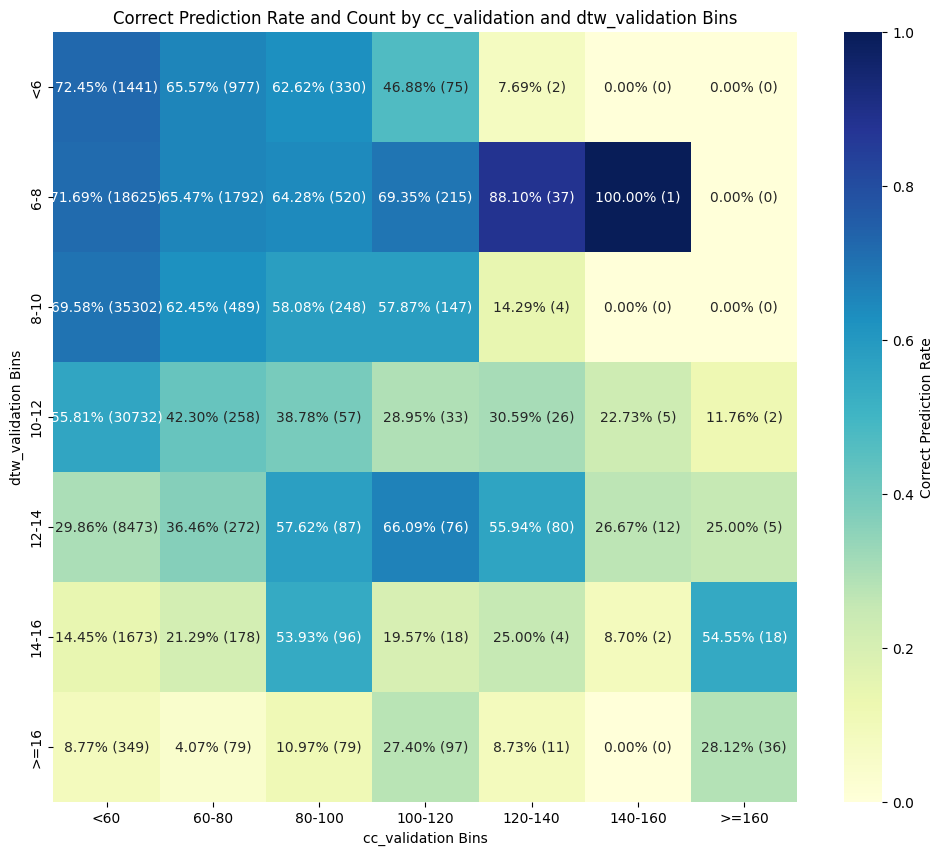

In [266]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `results_df` is your DataFrame with 'cc_validation', 'dtw_validation', and 'rmse_test' columns

# Define bins for `cc_validation` and `dtw_validation`
cc_bins = [0, 60, 80, 100, 120, 140, 160, float('inf')]
cc_labels = ['<60', '60-80', '80-100', '100-120', '120-140', '140-160', '>=160']

dtw_bins = [0, 6, 8, 10, 12, 14, 16, float('inf')]
dtw_labels = ['<6', '6-8', '8-10', '10-12', '12-14', '14-16', '>=16']

# Add a column to indicate whether the prediction is correct based on `rmse_test < 3`
results_df['correct_prediction'] = results_df['rmse_test'] < 3.5

# Bin the `cc_validation` and `dtw_validation` values
results_df['cc_bin'] = pd.cut(results_df['cc_validation'], bins=cc_bins, labels=cc_labels, right=False)
results_df['dtw_bin'] = pd.cut(results_df['dtw_validation'], bins=dtw_bins, labels=dtw_labels, right=False)

# Calculate the rate and count of correct predictions for each combination of `cc_bin` and `dtw_bin`
correct_count = results_df.groupby(['dtw_bin', 'cc_bin'])['correct_prediction'].sum().unstack()
total_count = results_df.groupby(['dtw_bin', 'cc_bin'])['correct_prediction'].count().unstack()
correct_rate = (correct_count / total_count).fillna(0)

# Create annotation text with rate and count in each cell
annot = correct_rate.applymap(lambda x: f"{x:.2%}") + correct_count.applymap(lambda x: f" ({int(x)})")

# Plot the heatmap with custom annotations
plt.figure(figsize=(12, 10))
sns.heatmap(correct_rate, annot=annot, fmt='', cmap='YlGnBu', cbar_kws={'label': 'Correct Prediction Rate'})
plt.xlabel('cc_validation Bins')
plt.ylabel('dtw_validation Bins')
plt.title('Correct Prediction Rate and Count by cc_validation and dtw_validation Bins')
plt.show()

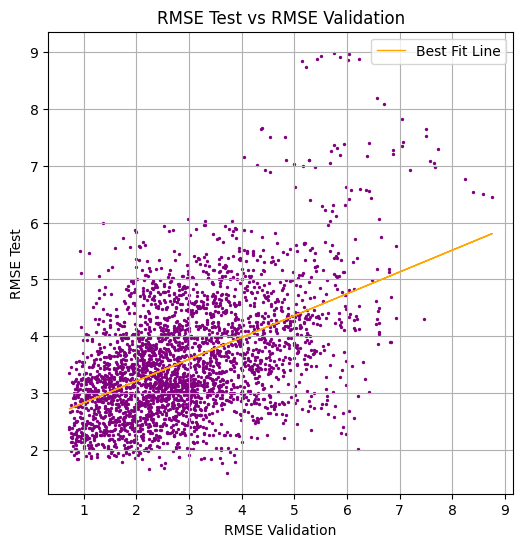

In [51]:
# Scatter plot of RMSE Test against RMSE Validation with smaller dots
plt.figure(figsize=(6, 6))
plt.scatter(results_df['rmse_validation'], results_df['rmse_test'], color='purple', s=2)

# Calculate the best-fit line using numpy's polyfit function
m, b = np.polyfit(results_df['rmse_validation'], results_df['rmse_test'], 1)  # 1st-degree polynomial for linear fit

# Plot the regression line
plt.plot(results_df['rmse_validation'], m * results_df['rmse_validation'] + b, color='orange', linewidth=1, label='Best Fit Line')

# Adding labels, title, and legend
plt.xlabel('RMSE Validation')
plt.ylabel('RMSE Test')
plt.title('RMSE Test vs RMSE Validation')
plt.legend()
plt.grid(True)
plt.show()

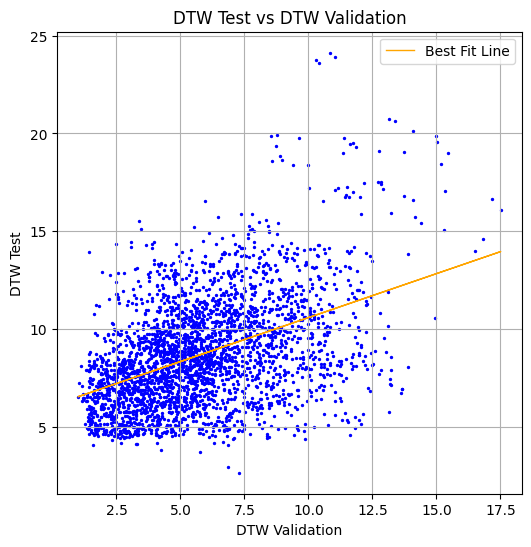

In [107]:
# Scatter plot of DTW Test distance against DTW Validation distance with smaller dots
plt.figure(figsize=(6, 6))
plt.scatter(results_df['dtw_validation'], results_df['dtw_test'], color='blue', s=2)

# Calculate the best-fit line using numpy's polyfit function
m, b = np.polyfit(results_df['dtw_validation'], results_df['dtw_test'], 1)  # 1st-degree polynomial for linear fit

# Plot the regression line
plt.plot(results_df['dtw_validation'], m * results_df['dtw_validation'] + b, color='orange', linewidth=1, label='Best Fit Line')

# Adding labels, title, and legend
plt.xlabel('DTW Validation')
plt.ylabel('DTW Test')
plt.title('DTW Test vs DTW Validation')
plt.legend()
plt.grid(True)
plt.show()

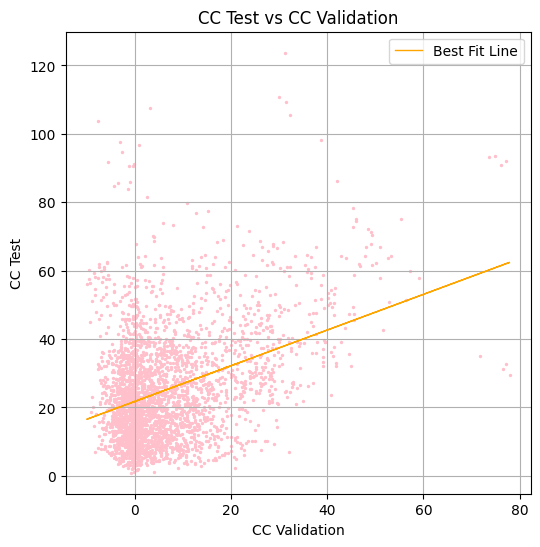

In [108]:
# Scatter plot of CC Test distance against CC Validation distance with smaller dots
plt.figure(figsize=(6, 6))
plt.scatter(results_df['cc_validation'], results_df['cc_test'], color='pink', s=2)

# Calculate the best-fit line using numpy's polyfit function
m, b = np.polyfit(results_df['cc_validation'], results_df['cc_test'], 1)  # 1st-degree polynomial for linear fit

# Plot the regression line
plt.plot(results_df['cc_validation'], m * results_df['cc_validation'] + b, color='orange', linewidth=1, label='Best Fit Line')

# Adding labels, title, and legend
plt.xlabel('CC Validation')
plt.ylabel('CC Test')
plt.title('CC Test vs CC Validation')
plt.legend()
plt.grid(True)
plt.show()

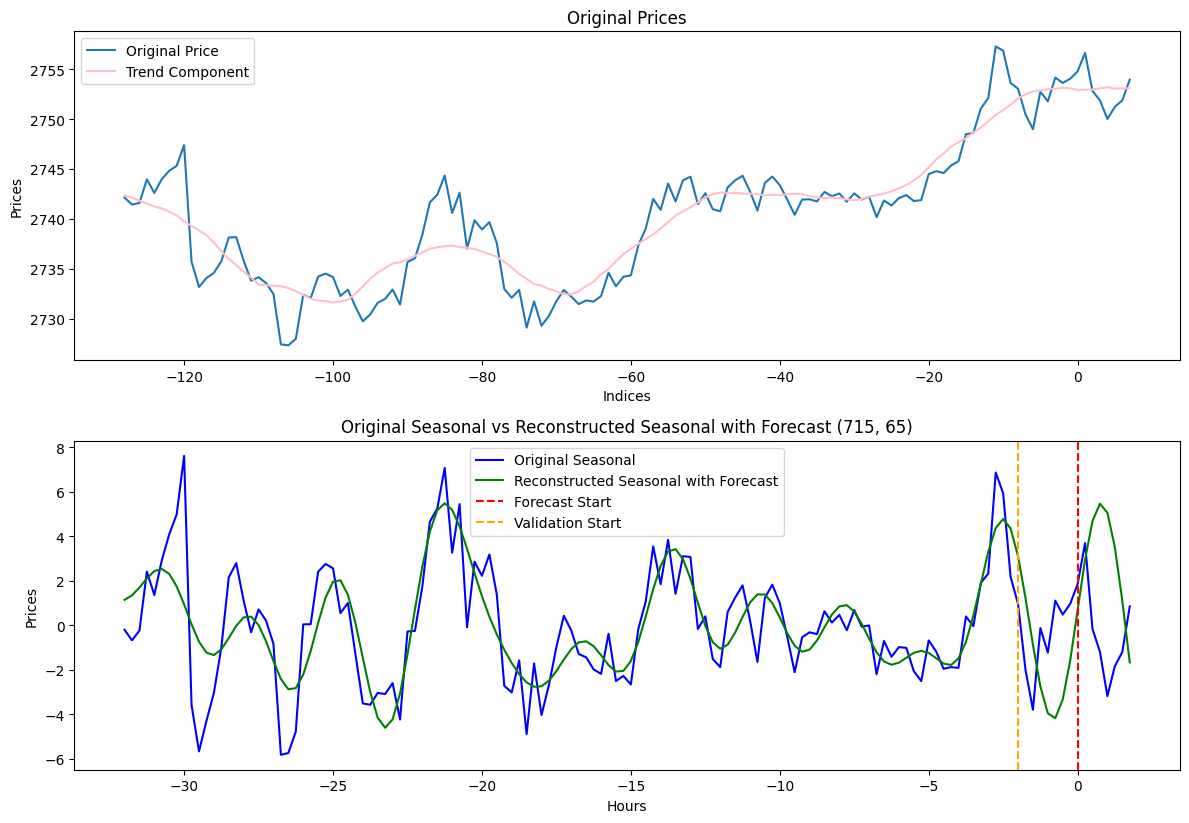

In [312]:
# Plotting for a specific run
seasonal_input_elements = 715
seasonal_harmonics = 65
run = 11

start_idx = len(yvalues_seasonal) - shift_step*run - test_elements - validation_elements - seasonal_input_elements
yvalues_seasonal_forecast, num_harmonics = fft_forecast( yvalues_seasonal[start_idx:start_idx+seasonal_input_elements],
                                                        validation_elements+test_elements,
                                                        seasonal_harmonics )

# Calculate slice indices
len_slice = visualization_elements + validation_elements + test_elements
slice_start_idx = -(shift_step * run + len_slice)
slice_end_idx = -shift_step * run
slice_idx_list = np.arange(-len_slice+test_elements, test_elements)

# Define a helper function for slicing with the condition
def safe_slice(data, start_idx, end_idx):
    return data[start_idx:] if end_idx == 0 else data[start_idx:end_idx]

# Apply the helper function to each slice
prices_slice = safe_slice(prices, slice_start_idx, slice_end_idx)
yvalues_trend_slice = safe_slice(yvalues_trend, slice_start_idx, slice_end_idx)
seasonal_original_slice = safe_slice(yvalues_seasonal, slice_start_idx, slice_end_idx)
seasonal_forecast_slice = yvalues_seasonal_forecast[-len_slice:]



# **6b. Plotting**
plt.figure(figsize=(12, 12))

# Plot original price and trend
plt.subplot(3, 1, 1)
plt.plot(slice_idx_list, prices_slice, label="Original Price")
plt.plot(slice_idx_list, yvalues_trend_slice, label='Trend Component', color='pink')
plt.title("Original Prices")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

# Plot original and reconstructed seasonal
plt.subplot(3, 1, 2)
plt.plot(slice_idx_list/4, seasonal_original_slice, label="Original Seasonal", color='blue')
plt.plot(slice_idx_list/4, seasonal_forecast_slice, label="Reconstructed Seasonal with Forecast", color='green')
plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
plt.axvline(x=-validation_elements/4, color='orange', linestyle='--', label="Validation Start")
plt.title(f"Original Seasonal vs Reconstructed Seasonal with Forecast ({seasonal_input_elements}, {seasonal_harmonics})")
plt.xlabel("Hours")
plt.ylabel("Prices")
plt.legend()

plt.tight_layout()
plt.show()